# Six Nations Home/Away Records

Scrapes all six nations matches and calculates home and away records based on probability density estimation

In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [37]:
# Scrape data from espnscrum.com
site = 'http://stats.espnscrum.com/scrum/rugby/records/team/match_results.html?'
# Six nations teams are nations 1, 2, 3, 4, 9 and 20
teams = [1, 2, 3, 4, 9, 20]
df = pd.DataFrame()
for team in teams:
    for year in range(2000,2020):
        page = site + 'id=' + str(year) + ';team=' + str(team) + ';type=year'
        df = df.append(pd.read_html(page)[0],ignore_index=True)

In [38]:
# Convert date to datetime
df['Datetime'] = pd.to_datetime(df['Date'])
df.sort_values('Datetime',inplace=True)

In [39]:
# Tidy up occaisions teams scored zero points
df.loc[df['HT']=='-','HT'] = 0
df.loc[df['HT.1']=='-','HT.1'] = 0

In [40]:
# Ensure all scores are numeric
df['HT'] = pd.to_numeric(df['HT'])
df['HT.1'] = pd.to_numeric(df['HT.1'])
df['Unnamed: 6']= pd.to_numeric(df['Unnamed: 6'])

In [41]:
# Drop duplicates
df.drop_duplicates(inplace=True,keep='first')
df = df[df['Series'].str.contains('Six Nations')]

In [42]:
# Have a look at the data
df.head(5)

,Team,Pts,Pts.1,Team.1,HT,HT.1,Unnamed: 6,Series,Ground,Date,Match,Datetime
0,England,50,18,Ireland,25,3,NaN,Six Nations / Millennium Trophy,Twickenham,5 Feb 2000,Details,2000-02-05
683,Wales,3,36,France,3,9,NaN,Six Nations,Millennium Stadium,5 Feb 2000,Details,2000-02-05
1159,Italy,34,20,Scotland,12,10,NaN,Six Nations,Rome,5 Feb 2000,Details,2000-02-05
236,Ireland,44,22,Scotland,13,10,NaN,Six Nations / Centenary Quaich,Lansdowne Road,19 Feb 2000,Details,2000-02-19
928,France,9,15,England,0,9,NaN,Six Nations,Stade de France,19 Feb 2000,Details,2000-02-19


Text(0.5, 0, 'Score Margin')

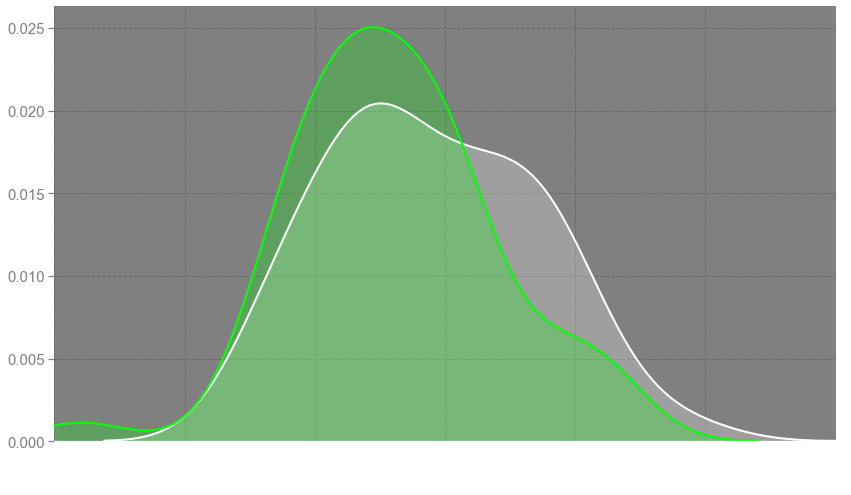

In [43]:
# Create comparison plot of win percentages for England vs Ireland
# Use seaborn kdeplot
home_nation = 'England'
away_nation = 'Ireland'
fig = plt.Figure(figsize=(6,8))
df_homenation = df[df['Team'] == home_nation]
df_awaynation = df[df['Team'] == away_nation]

plt.figure(figsize=(14,8))
sns.set_style("dark")
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey','xtick.color':'white', 'ytick.color':'grey',
            'grid.color':'dimgrey','ytick.left': True,'xtick.bottom': True,'axes.spines.right': False,
            'axes.spines.top': False,'axes.spines.right': False,'axes.spines.left': False,
           'grid.linestyle': '--','text.color': 'white',})
ax = sns.kdeplot(data = df_homenation['Pts']-df_homenation['Pts.1'], shade=True,color='white',linewidth=2)
ax  = sns.kdeplot(data = df_awaynation['Pts']-df_awaynation['Pts.1'], shade=True,color='lime',linewidth=2)
ax.set(xlim=(-40, 80))
ax.tick_params(labelsize=15)
ax.set_xlabel('Score Margin', fontsize=20 , color='white')

#ax = sns.distplot(df_homenation['Pts']-df_homenation['Pts.1'], kde=False, fit=stats.gamma, hist=None);
#ax = sns.distplot(df_awaynation['Pts']-df_awaynation['Pts.1'], kde=False, fit=stats.gamma, hist=None);

#l1 = ax.lines[0]
#l2 = ax.lines[1]

#x1 = l1.get_xydata()[:,0]
#y1 = l1.get_xydata()[:,1]
#x2 = l2.get_xydata()[:,0]
#y2 = l2.get_xydata()[:,1]
#ax.fill_between(x1,y1, alpha=0.3)
#ax.fill_between(x2,y2, alpha=0.3)

In [44]:
# Create dataframe to hold information for each nation
# Define some colors
df_nations = pd.DataFrame({'Nations': ['England','Ireland','Wales','Scotland','France','Italy'],
                         'Colors': ['white','lime','red','navy','blue','dodgerblue']})
df_nations['HomeMedian'] = ""
df_nations['AwayMedian'] = ""

In [45]:
# Use scipy to estimate probability and calculate cumulative probability of win
from scipy.stats import gaussian_kde
import scipy
x_grid = np.linspace(-80, 80, 1000)
medvals = []
for i in range(0,len(df_nations)):
    nation =df_nations['Nations'].iloc[i]
    df_homenation = df[df['Team'] == nation]
    df_awaynation = df[df['Team.1'] == nation]
    data_home = df_homenation['Pts']-df_homenation['Pts.1']
    data_away = df_awaynation['Pts.1']-df_awaynation['Pts']
    
    kde_home = gaussian_kde(dataset=data_home,bw_method='silverman')
    p_home = kde_home.evaluate(x_grid)
    cumval_home = kde_home.integrate_box_1d(0,80)
    df_nations['HomeMedian'].iloc[i] =cumval_home
    #df_nations['HomeMedian'].iloc[i] = x_grid[p_home.argmax()]
    
    kde_away = gaussian_kde(dataset=data_away,bw_method='silverman')
    p_away = kde_away.evaluate(x_grid)
    cumval_away = kde_away.integrate_box_1d(0,80)
    #df_nations['AwayMedian'].iloc[i] = x_grid[p_away.argmax()]
    df_nations['AwayMedian'].iloc[i] = cumval_away

In [46]:
# Sort nations
df_home = df_nations.sort_values(by='HomeMedian',ascending=False)
df_away = df_nations.sort_values(by='AwayMedian',ascending=False)

In [47]:
df_away

,Nations,Colors,HomeMedian,AwayMedian
0,England,white,0.832164,0.578297
1,Ireland,lime,0.767336,0.519566
4,France,blue,0.721689,0.505217
2,Wales,red,0.664844,0.473663
3,Scotland,navy,0.452418,0.170354
5,Italy,dodgerblue,0.221575,0.0814701


In [48]:
# Create some dataframes to hold stats to compare to KDE result
df_homeawaystats = pd.DataFrame({'Nations': ['England','Ireland','Wales','Scotland','France','Italy'],
                         'Colors': ['white','lime','red','navy','blue','dodgerblue']})
df_homeawaystats['HomeWins'] = ""
df_homeawaystats['AwayWins'] = ""
df_homeawaystats['HomeLosses'] = ""
df_homeawaystats['AwayLosses'] = ""
df_homeawaystats['HomeDraws'] = ""
df_homeawaystats['AwayDraws'] = ""
df_homeawaystats['Total'] = ""

In [49]:
for i in range(0,len(df_homeawaystats)):
    nation = df_homeawaystats['Nations'].iloc[i]
    df_homenation = df[df['Team'] == nation]
    homewins = len(df_homenation[df_homenation['Pts'] > df_homenation['Pts.1']])
    homelosses = len(df_homenation[df_homenation['Pts'] < df_homenation['Pts.1']])
    homedraws = len(df_homenation[df_homenation['Pts'] == df_homenation['Pts.1']])
 
    df_awaynation = df[df['Team.1'] == nation]
    awaywins = len(df_awaynation[df_awaynation['Pts.1'] > df_awaynation['Pts']])
    awaylosses = len(df_awaynation[df_awaynation['Pts.1'] < df_awaynation['Pts']])
    awaydraws = len(df_awaynation[df_awaynation['Pts.1'] == df_awaynation['Pts']])
    
    df_homeawaystats['HomeWins'].iloc[i] = homewins
    df_homeawaystats['AwayWins'].iloc[i] = awaywins
    df_homeawaystats['HomeLosses'].iloc[i] = homelosses
    df_homeawaystats['AwayLosses'].iloc[i] = awaylosses
    df_homeawaystats['HomeDraws'].iloc[i] = homedraws
    df_homeawaystats['AwayDraws'].iloc[i] = awaydraws
    df_homeawaystats['Total'].iloc[i] = homewins+awaywins+homelosses+awaylosses+homedraws+awaydraws

In [50]:
df_homeawaystats['HomePerc'] = df_homeawaystats['HomeWins']/(df_homeawaystats['HomeWins']+df_homeawaystats['HomeLosses']+df_homeawaystats['HomeDraws'])
df_homeawaystats['AwayPerc'] = df_homeawaystats['AwayWins']/(df_homeawaystats['AwayWins']+df_homeawaystats['AwayLosses']+df_homeawaystats['AwayDraws'])
df_homeawaystats

,Nations,Colors,HomeWins,AwayWins,HomeLosses,AwayLosses,HomeDraws,AwayDraws,Total,HomePerc,AwayPerc
0,England,white,42,27,7,22,1,1,100,0.84,0.54
1,Ireland,lime,38,28,10,21,2,1,100,0.76,0.56
2,Wales,red,33,24,16,24,1,2,100,0.66,0.48
3,Scotland,navy,21,7,27,42,2,1,100,0.42,0.14
4,France,blue,37,24,12,25,1,1,100,0.74,0.48
5,Italy,dodgerblue,10,2,40,47,0,1,100,0.2,0.04


In [51]:
# We will use stats to orderr the KDE plots
df_nations['HomeMedian'] = df_homeawaystats['HomePerc']
df_nations['AwayMedian'] = df_homeawaystats['AwayPerc']

df_home = df_nations.sort_values(by='HomeMedian',ascending=False)
df_away = df_nations.sort_values(by='AwayMedian',ascending=False)

In [52]:
# Notice that the cumulative pde predicts France will have a higher away win percentage than Wales (at time of writing), but in actual fact they are the same
# We will use actual win percentage to order the plots and include these values on plot
df_away

,Nations,Colors,HomeMedian,AwayMedian
1,Ireland,lime,0.76,0.56
0,England,white,0.84,0.54
2,Wales,red,0.66,0.48
4,France,blue,0.74,0.48
3,Scotland,navy,0.42,0.14
5,Italy,dodgerblue,0.2,0.04


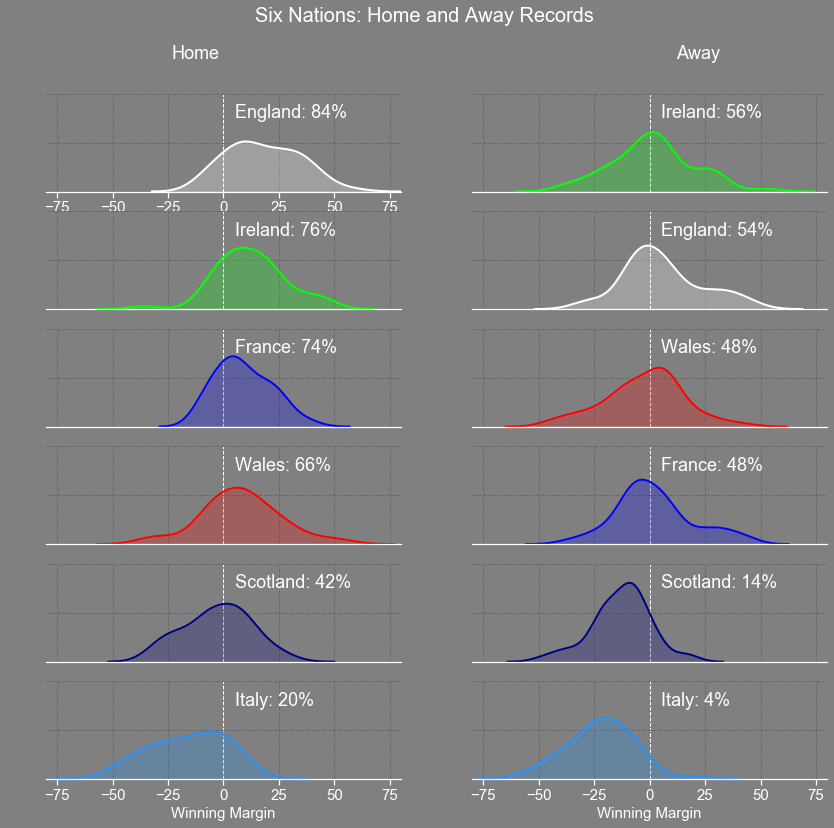

In [53]:
# Create plot - lots of trial and error to get right!
num = len(df_nations)
fig = plt.figure(figsize=(14,24))
#fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 24), constrained_layout=True)
for i in range(0,num):
    ax = fig.add_subplot(num*2,2,2*i+1)
    #ax = axes[i,0]
    home_nation = df_home['Nations'].iloc[i]
    df_homenation = df[df['Team'] == home_nation]
    homewins = float(df_homeawaystats[df_homeawaystats['Nations']==home_nation]['HomeWins'])
    hometotal = homewins + float(df_homeawaystats[df_homeawaystats['Nations']==home_nation]['HomeLosses']) + float(df_homeawaystats[df_homeawaystats['Nations']==home_nation]['HomeDraws'])
    homeperc = homewins/hometotal
        
    sns.set_style("dark")
    sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey','xtick.color':'grey', 'ytick.color':'grey',
                'grid.color':'dimgrey','ytick.left': True,'xtick.bottom': True,'axes.spines.right': False,
                'axes.spines.top': False,'axes.spines.right': False,'axes.spines.left': False,
               'grid.linestyle': '--','text.color': 'white',})
    ax = sns.kdeplot(data = df_homenation['Pts']-df_homenation['Pts.1'], shade=True,color=df_home['Colors'].iloc[i],linewidth=2,ax=ax)
    ax.set(xlim=(-80, 80))
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Winning Margin', fontsize=15 , color='white')
    #plt.title(home_nation,fontsize=18)
    if i == len(df_nations)-1:
        ax.tick_params(axis='x', colors='white')
    a = ax.get_xgridlines()
    b = a[4]
    b.set_color('white')
    ymin, ymax = ax.get_ylim()
    ax.set(ylim=(0, 0.04))
    s = "{0}: {1:.0%}".format(home_nation,homeperc)
    ax.text(x=5, y=0.03, s=s, fontsize=18)
    
    #ax = axes[i,1]
    ax = fig.add_subplot(num*2,2,2*i+2)
    away_nation = df_away['Nations'].iloc[i]
    df_awaynation = df[df['Team.1'] == away_nation]
    awaywins = float(df_homeawaystats[df_homeawaystats['Nations']==away_nation]['AwayWins'])
    awaytotal = awaywins + float(df_homeawaystats[df_homeawaystats['Nations']==away_nation]['AwayLosses']) + float(df_homeawaystats[df_homeawaystats['Nations']==away_nation]['AwayDraws'])
    awayperc = awaywins/awaytotal
    ax = sns.kdeplot(data = df_awaynation['Pts.1']-df_awaynation['Pts'], shade=True,color=df_away['Colors'].iloc[i],linewidth=2,ax=ax)
    ax.set(xlim=(-80, 80))
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Winning Margin', fontsize=15 , color='white')
    #plt.title(home_nation,fontsize=18)
    if i == len(df_nations)-1:
        ax.tick_params(axis='x', colors='white')
    a = ax.get_xgridlines()
    b = a[4]
    b.set_color('white')
    ymin, ymax = ax.get_ylim()
    ax.set(ylim=(0, 0.04))
    s = "{0}: {1:.0%}".format(away_nation,awayperc)
    ax.text(x=5, y=0.03, s=s, fontsize=18)
    
fig.suptitle("Six Nations: Home and Away Records", fontsize='20')
#fig.tight_layout()
fig.subplots_adjust(top=0.93) 
fig.text(x=0.25,y=0.95,s='Home',fontsize=18)
fig.text(x=0.75,y=0.95,s='Away',fontsize=18)

# Print plot
plt.savefig('sixnations_home_away_records.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')